### 座標とポテンシャルエネルギーを訓練データとして、エネルギー関数のパラメータ($\epsilon$と$\sigma$)を学習する

### 必要なパッケージを読み込む

In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
using Distributions
import MDToolbox

### ポテンシャルエネルギー関数の定義

In [2]:
function compute_energy(coords1, coords2, epsilon, sigma)
    r = sqrt(sum((coords1 .- coords2).^2))
    U = epsilon * ((sigma/r)^12 - 2 * (sigma/r)^6)
    return U
end

compute_energy (generic function with 1 method)

In [206]:
function ChainRulesCore.rrule(::typeof(compute_energy), coords1, coords2, epsilon, sigma)
    dx = coords1 .- coords2
    r = sqrt(sum(dx.^2))
    U = epsilon * ((sigma / r)^12 - 2 * (sigma / r)^6) 

    function compute_energy_pullback(dU)
        dcoords1 = -12 * epsilon * ((sigma^12 / r^14) - (sigma^6 / r^8)) .* dx .* dU
        dcoords2 = - dcoords1
        depsilon = ((sigma / r)^12 - 2 * (sigma / r)^6) * dU
        dsigma = 12 * epsilon * (sigma^11 / r^12 - sigma^5 / r^6) * dU 
        return NoTangent(), dcoords1, dcoords2, depsilon, dsigma
    end
    return U, compute_energy_pullback
end

In [207]:
#二原子のトラジェクトリからFを計算
function compute_free_energy(coords1_trj, coords2_trj, beta, epsilon, sigma)
    N = size(coords1_trj, 1)
    U_array = [compute_energy(coords1, coords2, epsilon, sigma) for (coords1, coords2) in zip(coords1_trj, coords2_trj)]
    #F = (-1 / beta) * log((1 / N) * sum(exp.(-beta .* U_array)))
    F = (-1 / beta) * (log(1 / N) + MDToolbox.logsumexp_1d(-beta .* U_array))
    return F
end

compute_free_energy (generic function with 1 method)

In [208]:
# exponential averaging
function compute_deltaF(coords_trj , beta, epsilon, sigma, U_array)
    N = size(coords_trj, 1)
    U_target_array = [compute_energy(coords1, coords2, epsilon, sigma) for (coords1, coords2) in coords_trj]
    deltaU = U_target_array .- U_array
    #@show deltaU
    #deltaF = (-1 / beta) * log((1 / N) * sum(exp.(-beta .* deltaU)))
    deltaF = (-1 / beta) * (log(1 / N) + MDToolbox.logsumexp_1d(-beta .* deltaU))
    return deltaF
end

compute_deltaF (generic function with 1 method)

### MCMCの定義

In [252]:
#次のステップ候補点
function next_coords(coords1, coords2, delta_x = 1e-1)
    next_coords1 = coords1 .+ (rand(3) .- 0.5) .* delta_x
    next_coords2 = coords2 .+ (rand(3) .- 0.5) .* delta_x
    return next_coords1, next_coords2
end

next_coords (generic function with 2 methods)

In [253]:
#MCMC,メトロポリス法
function mcmc(coords1, coords2, epsilon, sigma, nstep = 100, beta = 1.0)
    coords1_trj = []
    coords2_trj = []
    alpha_trj = []
    push!(coords1_trj, coords1)
    push!(coords2_trj, coords2)
    
    for i in 1:nstep
        next_coords1, next_coords2 = next_coords(coords1, coords2) #候補点
        next_U = compute_energy(next_coords1, next_coords2, epsilon, sigma)
        current_U = compute_energy(coords1, coords2, epsilon, sigma)
        delta_U = next_U - current_U
        alpha = exp(-beta * delta_U) #相対確率
        
        #alpha>=1またはalpha<1のとき確率alphaで候補を受理
        if alpha > rand()
            coords1 .= next_coords1
            coords2 .= next_coords2
        end     
        push!(coords1_trj, copy(coords1))
        push!(coords2_trj, copy(coords2))
        push!(alpha_trj, alpha)
    end
    return coords1_trj, coords2_trj, alpha_trj
end

mcmc (generic function with 3 methods)

### ΔFを求める

In [295]:
epsilon = 1.0
sigma = 4.0

epsilon_target = 1.1
sigma_target = 4.1

#kB = 1.380649e-23 #ボルツマン定数
kBT = 0.1
beta = 1.0/(kBT)

#seed_value = 123 #乱数固定
#Random.seed!(seed_value)

coords = ([0.0, 0.0, 0.0], [2.0, 0.0, 0.0]) #初期座標
coords_target = ([0.0, 0.0, 0.0], [2.5, 0.0, 0.0])
nstep = 1000000

trj1, trj2, alpha = mcmc(coords[1], coords[2], epsilon, sigma, nstep, beta)
trj1_target, trj2_target, alpha = mcmc(coords_target[1], coords_target[2], epsilon_target, sigma_target, nstep, beta)

@show F = compute_free_energy(trj1, trj2, beta, epsilon, sigma)
@show F_target = compute_free_energy(trj1_target, trj2_target, beta, epsilon_target, sigma_target)

@show delta_F = F_target - F

F = compute_free_energy(trj1, trj2, beta, epsilon, sigma) = -0.9584485332633975
F_target = compute_free_energy(trj1_target, trj2_target, beta, epsilon_target, sigma_target) = -1.060054061152416
delta_F = F_target - F = -0.10160552788901855


-0.10160552788901855

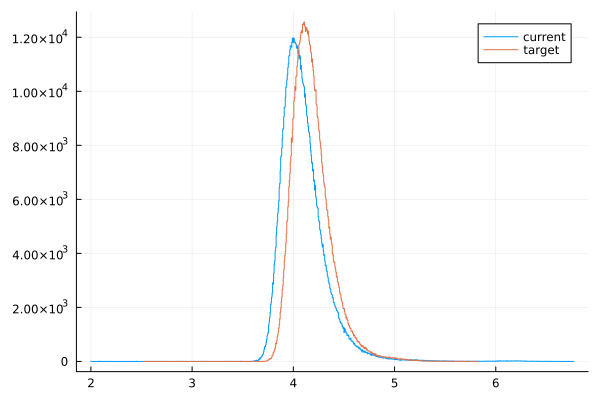

In [296]:
r = [sqrt(sum((x - y).^2)) for (x, y) in zip(trj1, trj2)]
histogram(r,label="current")
r = [sqrt(sum((x - y).^2)) for (x, y) in zip(trj1_target, trj2_target)]
histogram!(r,label="target")

In [297]:
#ポテンシャルエネルギーの配列
U_array = map(x -> compute_energy(x[1], x[2], epsilon, sigma), zip(trj1, trj2))

#パラメータ推定に用いる原子の軌跡と自由エネルギーの差
X_train = collect(zip(trj1, trj2))
y_train = delta_F

-0.10160552788901855

In [298]:
# Sanity check
@show compute_deltaF(X_train, beta, epsilon, sigma, U_array)

@show compute_deltaF(X_train, beta, epsilon_target, sigma_target, U_array)

compute_deltaF(X_train, beta, epsilon, sigma, U_array) = -0.0
compute_deltaF(X_train, beta, epsilon_target, sigma_target, U_array) = -0.10156294426182698


-0.10156294426182698

### 勾配法で訓練してK(バネ定数)とR(平衡長)を推定

In [327]:
struct EXP
    P::AbstractArray #P[1] = epsilon, P[2] = sigma
end

Flux.@functor EXP (P,)

(m::EXP)(coords_trj) = compute_deltaF(coords_trj, beta, m.P[1], m.P[2], U_array)

In [340]:
# Lossの定義
m = EXP([epsilon, sigma])
loss(X, y) = Flux.Losses.mse(m(X), y)
loss(X_train, y_train)

0.010323683297606127

In [341]:
# DataやOptimizerの定義
#train_loader = Flux.Data.DataLoader(X_train, batchsize=10, shuffle=true)
ps = Flux.params(m)
opt = ADAM(1e-2)

Adam(0.01, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [342]:
# コールバック関数の定義
function print_callback(epoch, loss, ps)
    println("Epoch: $epoch, loss: $loss")
    println("param: $(ps[1])")
end

print_callback (generic function with 1 method)

In [343]:
# 訓練
loss_train = []

for epoch in 1:100
    gs = gradient(() -> loss(X_train, y_train), ps)
    Flux.Optimise.update!(opt, ps, gs)
    
    L = loss(X_train, y_train)
    push!(loss_train, L)
    print_callback(epoch, L, ps)
end

Epoch: 1, loss: 6310.075602209037
param: [1.0099999994331854, 3.990000003974502]
Epoch: 2, loss: 0.007312830669417006
param: [1.017441369601235, 3.99744137212091]
Epoch: 3, loss: 0.006349995528996188
param: [1.023193571980313, 4.00319357131035]
Epoch: 4, loss: 0.0056115054456397605
param: [1.0279054275774209, 4.007905422914147]
Epoch: 5, loss: 0.005022694309168591
param: [1.031888021243501, 4.011888011985604]
Epoch: 6, loss: 0.004541256873514764
param: [1.0353205029374095, 4.0153204886143765]
Epoch: 7, loss: 0.004140555276414955
param: [1.0383181044439207, 4.0183180846774595]
Epoch: 8, loss: 0.003802588174679201
param: [1.0409606713423842, 4.02096064582292]
Epoch: 9, loss: 0.0035145639000049088
param: [1.043306573966076, 4.023306542437188]
Epoch: 10, loss: 0.003267046364412353
param: [1.0454002391524204, 4.025400201399894]
Epoch: 11, loss: 0.0030528711345203918
param: [1.0472765575857266, 4.0272765134294914]
Epoch: 12, loss: 0.002866472744320059
param: [1.0489636226640384, 4.0289635719

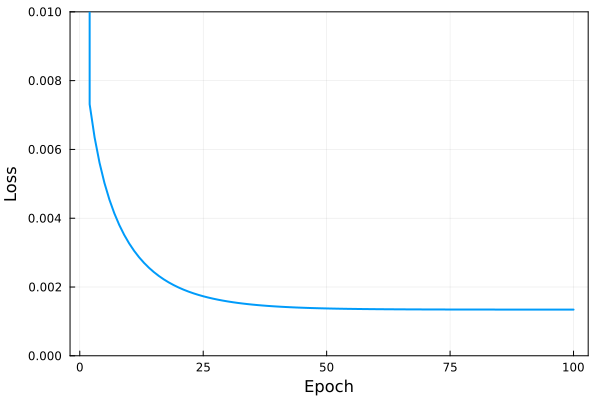

In [350]:
plot(loss_train, legend=nothing, framestyle=:box, linewidth=2, ylims=(0.0, 0.01))
ylabel!("Loss")
xlabel!("Epoch")

In [351]:
println("Initial epsilon:   ", epsilon)
println("Estimated epsilon: ", m.P[1])
println("Target epsilon:    ", epsilon_target)
println()
println("Initial sigma:   ", sigma)
println("Estimated sigma: ", m.P[2])
println("Target sigma:    ", sigma_target)

Initial epsilon:   1.0
Estimated epsilon: 1.065586612223772
Target epsilon:    1.1

Initial sigma:   4.0
Estimated sigma: 4.045585787192477
Target sigma:    4.1


In [352]:
# Sanity check
@show delta_F

@show compute_deltaF(X_train, beta, m.P[1], m.P[2], U_array)

delta_F = -0.10160552788901855
compute_deltaF(X_train, beta, m.P[1], m.P[2], U_array) = -0.06495955323038878


-0.06495955323038878